# Malay Text Classification using ULMFiT

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Imports

In [44]:
import json
import pathlib
import html
import numpy as np
import pandas as pd
from unidecode import unidecode

from fastai.text import *

## Download data

In [8]:
!ls -la data/model/malay

total 881768
drwxrwxr-x 3 ubuntu ubuntu      4096 Sep 22 11:27 .
drwxrwxr-x 3 ubuntu ubuntu      4096 Sep 22 10:05 ..
-rw-rw-r-- 1 ubuntu ubuntu 282627815 Sep 22 10:05 malay2vec_embeddings.csv
-rw-rw-r-- 1 ubuntu ubuntu  19881603 Sep 21 11:09 test.csv
drwxrwxr-x 2 ubuntu ubuntu      4096 Sep 22 11:26 tmp
-rw-rw-r-- 1 ubuntu ubuntu 180414425 Sep 21 11:09 train.csv
-rw-rw-r-- 1 ubuntu ubuntu 219657951 Sep 21 10:29 wiki_malay_corpus.csv
-rw-rw-r-- 1 ubuntu ubuntu 200324811 Sep 21 10:29 wiki_malay_corpus_sorted_by_len.csv


In [21]:
!mkdir -p data/model/malay/dataset/malaya

In [22]:
!curl -o data/model/malay/dataset/malaya/sentiment-data-v2.csv \
--header 'Accept: application/vnd.github.v3.raw' \
--remote-name \
--location https://api.github.com/repos/DevconX/Malaya/contents/dataset/sentiment-data-v2.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  484k  100  484k    0     0   484k      0  0:00:01  0:00:01 --:--:--  267k


In [48]:
!curl -o data/model/malay/dataset/malaya/polarity-negative-translated.txt \
--header 'Accept: application/vnd.github.v3.raw' \
--remote-name \
--location https://api.github.com/repos/DevconX/Malaya/contents/dataset/polarity-negative-translated.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  620k  100  620k    0     0   620k      0  0:00:01  0:00:01 --:--:--  392k


In [49]:
!curl -o data/model/malay/dataset/malaya/polarity-positive-translated.txt \
--header 'Accept: application/vnd.github.v3.raw' \
--remote-name \
--location https://api.github.com/repos/DevconX/Malaya/contents/dataset/polarity-positive-translated.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  625k  100  625k    0     0   625k      0  0:00:01  0:00:01 --:--:--  333k


In [23]:
!ls -lah data/model/malay/dataset/malaya

total 496K
drwxrwxr-x 2 ubuntu ubuntu 4.0K Nov  7 17:05 .
drwxrwxr-x 3 ubuntu ubuntu 4.0K Nov  7 17:05 ..
-rw-rw-r-- 1 ubuntu ubuntu 485K Nov  7 17:05 sentiment-data-v2.csv


In [24]:
!cat data/model/malay/dataset/malaya/sentiment-data-v2.csv | head -n 10

label,text
Negative,"Lebih-lebih lagi dengan  kemudahan internet dan laman sosial, taktik ini semakin mudah dikembangkan."
Positive,boleh memberi teguran kepada parti tetapi perlu ikut cara yang betul
Negative,Adalah membingungkan mengapa masyarakat Cina bersorak gembira apabila Mahathir menyertai gabungan pakatan pembangkang
Positive,Kami menurunkan defisit daripada 6.7 peratus pada tahun 2009 kepada tiga peratus pada tahun lalu
Negative,"Ini masalahnya. Bukan rakyat, tetapi sistem"
Positive,Masyarakat Cina dapat melihat bagaimana perancangan kerajaan di bawah pimpinan perdana menteri merangka pembangunan dan berjaya melaksanakannya dan mereka juga dapat melihat bagaimana pembangkang tidak dapat melaksanakan janji-janji yang pernah dibuat sebelum ini.
Positive,"Tetapi penyelenggaraan ini ada skop tertentu yang perlu mendapat kelulusan Kementerian Kewangan dan ia merangkumi pembaikan kecil seperti bumbung, tandas, paip dan kerja-kerja elektrikal sahaja"
Positive,"Jika memilih untuk tid

## Standardize data format

## Data

In [187]:
BOS = "xbos"  # beginning-of-sentence tag
FLD = "xfld"  # data field tag

LANG = 'malay'
DATA_PATH = 'data'

ROOT_PATH = Path(f"{DATA_PATH}/model/{LANG}/")

# Malaya dataset and LM
DATASET_PATH = Path(f'{ROOT_PATH}/dataset/malaya/')
PKL_PATH = Path(f'{DATASET_PATH}/pkl/')
TMP_PATH = Path(f'{DATASET_PATH}/tmp/')

# Wikipedia LM
MODELS_PATH = Path(f'{DATA_PATH}/models/')
PRETRAINED_WIKI_LM_PATH = Path(f'{ROOT_PATH}/tmp/')

In [26]:
df = pd.read_csv(DATASET_PATH / 'sentiment-data-v2.csv')

In [34]:
# SANITY CHECK
df.label.head()

0    Negative
1    Positive
2    Negative
3    Positive
4    Negative
Name: label, dtype: object

In [29]:
Y = preprocessing.LabelEncoder().fit_transform(df.label)
df.head()

,label,text
0,Negative,Lebih-lebih lagi dengan kemudahan internet da...
1,Positive,boleh memberi teguran kepada parti tetapi perl...
2,Negative,Adalah membingungkan mengapa masyarakat Cina b...
3,Positive,Kami menurunkan defisit daripada 6.7 peratus p...
4,Negative,"Ini masalahnya. Bukan rakyat, tetapi sistem"


In [35]:
# SANITY CHECK
Y.shape, Y[:5]

((3685,), array([0, 1, 0, 1, 0]))

In [36]:
# SANITY CHECK
df.shape[0]

3685

In [41]:
# SANITY CHECK
df.iloc[0, 1]

'Lebih-lebih lagi dengan\xa0 kemudahan internet dan laman sosial, taktik ini semakin mudah dikembangkan.'

### Process text

In [45]:
def textcleaning(string):
    """A simple helper function to clean text"""
    string = re.sub('http\S+|www.\S+', '',' '.join([i for i in string.split() if i.find('#')<0 and i.find('@')<0]))
    string = unidecode(string).replace('.', '. ').replace(',', ', ')
    string = re.sub('[^\'\"A-Za-z\- ]+', ' ', string)
    return ' '.join([i for i in re.findall("[\\w']+|[;:\-\(\)&.,!?\"]", string) if len(i)>1]).lower()

In [46]:
# Iterate over the df rows and clean the text and inline update the Pandas dataframe.
for i in range(df.shape[0]):
    df.iloc[i,1] = textcleaning(df.iloc[i,1])

In [47]:
# SANITY CHECK
df.iloc[0, 1]

'lebih lebih lagi dengan kemudahan internet dan laman sosial taktik ini semakin mudah dikembangkan'

**Concat sentiment dataset with polarity datasets**

In [50]:
with open(DATASET_PATH / 'polarity-negative-translated.txt','r') as fopen:
    texts = fopen.read().split('\n')
labels = [0] * len(texts)

In [66]:
# SANITY CHECK
len(texts), labels[:5]

(5306, [0, 0, 0, 0, 0])

In [59]:
with open(DATASET_PATH / 'polarity-positive-translated.txt','r') as fopen:
    positive_texts = fopen.read().split('\n')
labels += [1] * len(positive_texts)

In [61]:
# SANITY CHECK
len(positive_texts)

5288

In [67]:
texts += positive_texts # type of list
texts += df.iloc[:, 1].tolist() # get all rows for the 'text' column and returns as list
labels += Y.tolist() # append encoded labels of sentiment positive (1), negative (0)

assert len(labels) == len(texts) # if this prints nothing, it means no error and we are all good

**Simple analysis of vocab and common words**

In [68]:
def build_dataset(words, n_words):
    """A helper function to build dataset"""
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [74]:
concat = ' '.join(texts).split()
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)

print('Vocab from size: %d' % (vocabulary_size))
print('Most common words:', count[4:10])
print('Sample data:', data[:10], [rev_dictionary[i] for i in data[:10]])

Vocab from size: 18957
Most common words: [('yang', 14891), ('dan', 8177), ('tidak', 4578), ('untuk', 4023), ('dengan', 3349), ('filem', 3279)]
Sample data: [1606, 204, 5, 160, 217, 106, 300, 4, 78, 202] ['ringkas', 'bodoh', 'dan', 'membosankan', 'kanak-kanak', 'lelaki', 'remaja', 'yang', 'begitu', 'muda']


**Create final dataframe**

In [109]:
# SANITY CHECK
print(texts[5305:5306], labels[5305:5306]) # start of polarity-negative-translated.txt
print(texts[5306:5307], labels[5306:5307]) # start of polarity-positive-translated.txt
print(texts[5306 + 5288:5306 + 5288 + 1], labels[5306 + 5288:5306 + 5288 + 1]) # start of sentiment-data-v2.csv

['Enigma dibuat dengan baik tetapi terlalu kering dan terlalu tenang'] [0]
['batu itu ditakdirkan untuk menjadi 21 centurys baru conan dan bahawa dia akan membuat percikan yang lebih besar daripada arnold schwarzenegger jeanclaud van damme atau steven segal'] [1]
['lebih lebih lagi dengan kemudahan internet dan laman sosial taktik ini semakin mudah dikembangkan'] [0]


In [106]:
df_all = pd.DataFrame.from_records({ 'label': labels, 'text': texts })

In [118]:
df_all.head()

,label,text
0,0,ringkas bodoh dan membosankan
1,0,kanak-kanak lelaki remaja yang begitu muda dan...
2,0,eksploitatif dan sebahagian besarnya tidak mem...
3,0,Garbus membuang potensi untuk kajian patologi ...
4,0,senaman lucah tetapi terang secara terang-tera...


In [115]:
# SANITY CHECK
print(df_all.iloc[5305])
print(df_all.iloc[5306])
print(df_all.iloc[5306 + 5288:5306 + 5288 + 3])

label                                                    0
text     Enigma dibuat dengan baik tetapi terlalu kerin...
Name: 5305, dtype: object
label                                                    1
text     batu itu ditakdirkan untuk menjadi 21 centurys...
Name: 5306, dtype: object
       label                                               text
10594      0  lebih lebih lagi dengan kemudahan internet dan...
10595      1  boleh memberi teguran kepada parti tetapi perl...
10596      0  adalah membingungkan mengapa masyarakat cina b...


In [119]:
df_all.to_csv(f'{DATASET_PATH}/all.csv', header=False, index=False)

In [120]:
# SANITY CHECK
df_all.shape[0]

14279

In [127]:
df_all = pd.read_csv(f'{DATASET_PATH}/all.csv')
df_all.columns = ['label', 'text']

In [130]:
# SANITY CHECK
df_all.head()

,label,text
0,0,kanak-kanak lelaki remaja yang begitu muda dan...
1,0,eksploitatif dan sebahagian besarnya tidak mem...
2,0,Garbus membuang potensi untuk kajian patologi ...
3,0,senaman lucah tetapi terang secara terang-tera...
4,0,cerita itu juga tidak asli kerana mereka datan...


## Validation Sets

Split the data into train and validation sets. Splitting 10% for validation.

In [131]:
trn_texts, val_texts = sklearn.model_selection.train_test_split(df_all, test_size=0.1)

In [132]:
# SANITY CHECK
len(trn_texts), len(val_texts)

(12850, 1428)

In [137]:
np.random.seed(42)

trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx, :] # sort things randomly
df_val = val_texts.iloc[val_idx, :] # sort things randomly

In [142]:
df_trn.columns = ['label', 'text']
df_val.columns = ['label', 'text']

df_trn.to_csv(DATASET_PATH / 'train.csv', header=False, index=False)
df_val.to_csv(DATASET_PATH / 'test.csv', header=False, index=False) # saving the data in our new format to disk

In [145]:
chunksize = 10000
df_trn = pd.read_csv(DATASET_PATH / 'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(DATASET_PATH / 'test.csv', header=None, chunksize=chunksize)

## Data Preparation

We write a simple custom function to perform tokenization. Out of all tokens from all of training set, we chose 60,000 for the vocabulary size (plus one for unknown and another for padding) of tokens which are not rare words (appeared more than twice and not typos) in the training set.

We perform the following minimal text processing:

- The token `xbos` is used to note start of a text since we will be chaining them together for the language model training.

### Tokenize

In [150]:
# Utility functions
def get_texts(df, n_lbls=1):
    labels = df.iloc[:, range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls + 1, len(df.columns)):
        texts += f' {FLD} {i - n_lbls} ' + df[i].astype(str)
    # texts = texts.apply(fixup).values.astype(str) # create plain text

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts)) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_
        labels += labels_
    return tok, labels

In [151]:
# Finally, tokenize text data
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0


/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


1
0


In [153]:
# SANITY CHECK
tok_trn[:2]

[['\n',
  'xbos',
  'xfld',
  '1',
  'visi',
  'menghantui',
  'dengan',
  'imej',
  'yang',
  'kelihatan',
  'seperti',
  'halusinasi',
  'mengganggu'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  'sampah',
  'yang',
  'tidak',
  'masuk',
  'akal',
  'seperti',
  'ini',
  'yang',
  'membuat',
  'anda',
  'menghargai',
  'komedi',
  'romantis',
  'asal',
  'seperti',
  'cinta',
  'punchdrunk']]

### Data loader

In [157]:
# Create a tmp directory to store the upcoming numpy arrays
(TMP_PATH).mkdir(exist_ok=True)

# Save the train and validation tokens in the tmp directories
np.save(TMP_PATH / 'tok_trn.npy', tok_trn)
np.save(TMP_PATH / 'tok_val.npy', tok_val)

In [158]:
tok_trn = np.load(TMP_PATH / 'tok_trn.npy')
tok_val = np.load(TMP_PATH / 'tok_val.npy')

In [159]:
# SANITY CHECK
# get the first 2 train tokens
tok_trn[:2]

array([list(['\n', 'xbos', 'xfld', '1', 'visi', 'menghantui', 'dengan', 'imej', 'yang', 'kelihatan', 'seperti', 'halusinasi', 'mengganggu']),
       list(['\n', 'xbos', 'xfld', '1', 'sampah', 'yang', 'tidak', 'masuk', 'akal', 'seperti', 'ini', 'yang', 'membuat', 'anda', 'menghargai', 'komedi', 'romantis', 'asal', 'seperti', 'cinta', 'punchdrunk'])],
      dtype=object)

Get the `Counter` object from all the splitted files. Identify the most common tokens.

In [163]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('yang', 13305),
 ('1', 12858),
 ('\n', 12850),
 ('xbos', 12850),
 ('xfld', 12850),
 ('dan', 7389),
 ('tidak', 4095),
 ('untuk', 3592),
 ('-', 3476),
 ('filem', 3276),
 ('dengan', 2994),
 ('ini', 2639),
 ('dalam', 2199),
 ('di', 2161),
 ('adalah', 1909),
 ('tetapi', 1623),
 ('itu', 1556),
 ('ia', 1369),
 ('lebih', 1314),
 ('anda', 1268),
 ('mereka', 1254),
 ('kita', 1222),
 ('akan', 1199),
 ('saya', 1167),
 ('pada', 1047)]

In [164]:
# SANITY CHECK
len([p for o in tok_trn for p in o])

277225

In [165]:
cnt = []
for i in range(49):
    row_cnt = freqs[freqs[0]>=i+1].shape[0]
    cnt.append(row_cnt)

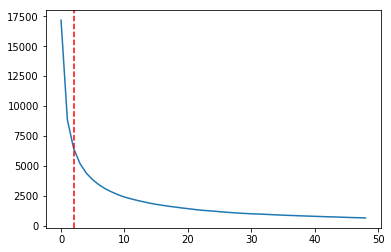

In [166]:
plt.plot(cnt)
plt.axvline(x=2, color="red", linestyle="--")

 ## Numericalize the text

In [167]:
# Truncating our vocab to ignore the rare words
max_vocab = 60000
min_freq = 5

In [168]:
itos = [o for o, c in freq.most_common(max_vocab) if c > min_freq] # getting rid of the rare words
itos.insert(0, "_pad_")
itos.insert(0, "_unk_") # itos is the list of all the strings in the vocab

In [169]:
# Creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda: 0, {v:k for k, v in enumerate(itos)})
len(itos)

3826

In [170]:
# Creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [172]:
# SANITY CHECK
trn_lm[:3]

array([list([4, 5, 6, 3, 1476, 1417, 12, 471, 2, 164, 28, 0, 538]),
       list([4, 5, 6, 3, 757, 2, 8, 181, 226, 28, 13, 2, 58, 21, 1160, 85, 253, 415, 28, 172, 0]),
       list([4, 5, 6, 3, 19, 585, 12, 0, 0, 2, 8, 356, 7, 3071, 183, 2, 109, 8, 44, 0])], dtype=object)

In [174]:
# Create a pkl directory to store the upcoming pickled object
(PKL_PATH).mkdir(exist_ok=True)

In [175]:
# Saving our indexed representation of our dataset to disk.
# We also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(TMP_PATH / 'trn_ids.npy', trn_lm)
np.save(TMP_PATH / 'val_ids.npy', val_lm)
pickle.dump(itos, open(PKL_PATH / 'itos.pkl', 'wb'))

In [176]:
# Loading the indexed representation of our dataset from disk.
# We also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(TMP_PATH / 'trn_ids.npy')
val_lm = np.load(TMP_PATH / 'val_ids.npy')
itos = pickle.load(open(PKL_PATH / 'itos.pkl', 'rb'))

In [178]:
# Check vocabulary size
vocab_size = len(itos)
trn_set_size = len(trn_lm)
val_set_size = len(val_lm)
vocab_size, trn_set_size, val_set_size

(3826, 12850, 1428)

In [180]:
# SANITY CHECK
trn_lm[:3]

array([list([4, 5, 6, 3, 1476, 1417, 12, 471, 2, 164, 28, 0, 538]),
       list([4, 5, 6, 3, 757, 2, 8, 181, 226, 28, 13, 2, 58, 21, 1160, 85, 253, 415, 28, 172, 0]),
       list([4, 5, 6, 3, 19, 585, 12, 0, 0, 2, 8, 356, 7, 3071, 183, 2, 109, 8, 44, 0])], dtype=object)

## Model Setup

Set hyper-parameters

In [339]:
em_sz = 400  # size of each embedding vector
nh = 1150    # number of hidden activations per layer
nl = 3       # number of layers

wd = 1e-7
bptt = 70
bs = 64
# opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
opt_fn = partial(optim.SGD, momentum=0.9)
weight_factor = 0.1 # was 0.3

#### Load weights for the pre-trained model for Malay Wikipedia dataset

In [183]:
PRETRAINED_LM_PATH = MODELS_PATH / 'lm_malay_final.h5'

In [184]:
wgts = torch.load(PRETRAINED_LM_PATH, map_location=lambda storage, loc: storage)

In [185]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [188]:
itos_wiki = pickle.load((PRETRAINED_WIKI_LM_PATH / 'itos.pkl').open('rb'))
stoi_wiki = collections.defaultdict(lambda:-1, {v:k for k, v in enumerate(itos_wiki)})

Map Malaya vocab to Wikipedia LM embeddings:

In [190]:
new_w = np.zeros((vocab_size, em_sz), dtype=np.float32)

for i, w in enumerate(itos):
    r = stoi_wiki[w]
    new_w[i] = enc_wgts[r] if r >= 0 else row_m

Update Wikipedia LM weights

In [191]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

### Language Model

In [192]:
# if you're overfitting, increase this. Underfitting? decrease this.
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * weight_factor

In [193]:
%time
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(DATASET_PATH, pad_idx=1, n_tok=vocab_size, trn_dl=trn_dl, val_dl=val_dl, bs=bs, bptt=bptt)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


In [340]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
# learner.clip = 0.2
learner.freeze_to(-1)

In [341]:
learner.model.load_state_dict(wgts)

#### AWD-LSTM network

In [342]:
learner.summary

<bound method Learner.summary of SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(3826, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(3826, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout()
    (dropouths): ModuleList(
      (0): LockedDropout()
      (1): LockedDropout()
      (2): LockedDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=3826, bias=False)
    (dropout): LockedDropout()
  )
)>

### Train

**Hyper-parameter search**

Properly setting the hyper-parameters of a neural network can be challenging, thankfully, there are some technique that can help.

We will speed up training using Leslie Smith's work on 1cycle policy that he described the [super-convergence] phenomenon in this [paper](https://arxiv.org/abs/1708.07120). Here's an [application of super-convergence to win the DAWNBench challenge](http://www.fast.ai/2018/04/30/dawnbench-fastai/).

Based on my own experiments with this method previously, the AWS-LSTM model converged faster, instead of 15 epochs, now it takes just 10 epochs.

We will be using an [implementation of this method](http://forums.fast.ai/t/the-1cycle-policy-an-experiment-that-investigate-super-convergence-phenomenon-described-in-leslie-smiths-research/14737):
- A simple guide on how to use 1cycle policy [Cyclical Learning Rate (CLR)](http://forums.fast.ai/t/using-use-clr-beta-and-new-plotting-tools/14702)
- Some [tips on super-convergence(ish) on WikiText-2](http://forums.fast.ai/t/super-convergence-ish-on-wikitext-2/17091), a similar LM task like ours.

In [343]:
# Find learning rate
learner.lr_find(wds=wd, end_lr=1000)

 97%|█████████▋| 58/60 [00:17<00:00,  3.30it/s, loss=22.1]

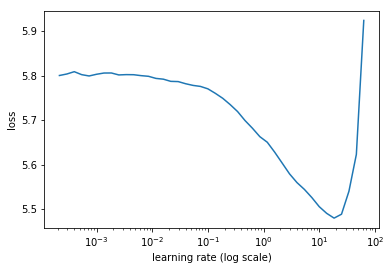

In [345]:
learner.sched.plot()

In [346]:
# Set learning rate
lr = 10 # 8e-4
lrs = lr

In [347]:
%time
learner.fit(lrs / 2, 1, wds=wd, use_clr=(32, 2), cycle_len=1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


epoch      trn_loss   val_loss   accuracy                 
    0      4.557393   4.237017   0.312686  


[4.23701696395874, 0.3126858949661255]

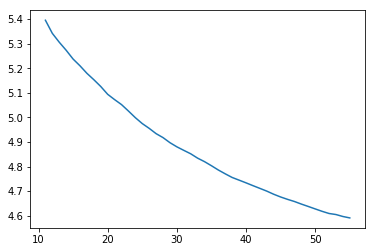

In [348]:
learner.sched.plot_loss()

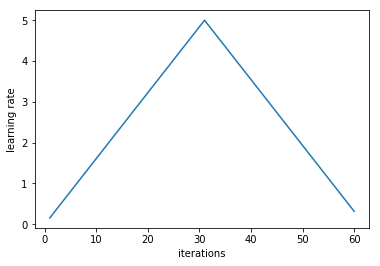

In [349]:
learner.sched.plot_lr()

In [352]:
%time
learner.fit(lrs / 2, 5, wds=wd, use_clr=(32, 2), cycle_len=1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


epoch      trn_loss   val_loss   accuracy                 
    0      4.279974   4.146692   0.314382  
    1      4.162824   4.110045   0.318157                 
    2      4.10558    4.096226   0.31969                  
    3      4.067971   4.091104   0.319405                 
    4      4.039491   4.080481   0.321299                 


[4.080480575561523, 0.32129873633384703]

In [353]:
learner.save('lm_malay_class_freeze_to_neg_1')

In [355]:
learner.load('lm_malay_class_freeze_to_neg_1')

In [356]:
%time
learner.fit(lrs / 2, 1, wds=wd, use_clr=(32, 2), cycle_len=1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


epoch      trn_loss   val_loss   accuracy                 
    0      4.011796   4.072989   0.321525  


[4.072989368438721, 0.321524578332901]

In [357]:
learner.save('lm_malay_class_freeze_to_neg_2')

In [372]:
learner.load('lm_malay_class_freeze_to_neg_2')

In [373]:
learner.unfreeze()

In [335]:
%time
learner.lr_find2(num_it=1000)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


 67%|██████▋   | 40/60 [00:21<00:10,  1.83it/s, loss=4.04]

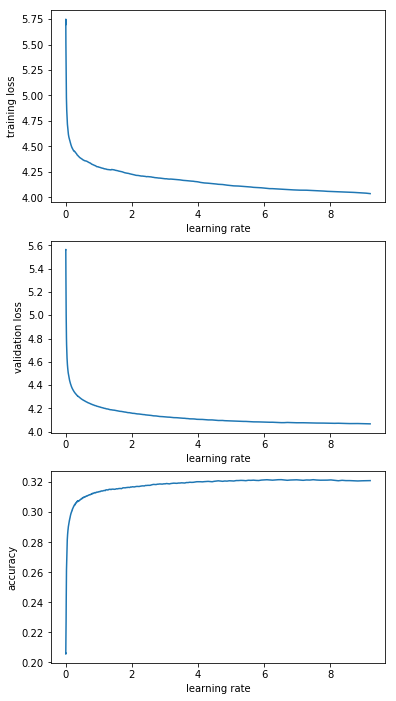

In [336]:
learner.sched.plot()

In [374]:
# Set learning rate
lr = 0.2

In [375]:
learner.fit(lr, 1, wds=wd, cycle_len=35, use_clr=(10,33,0.95,0.85), best_save_name='best_lm_malay_class_1cycle')

epoch      trn_loss   val_loss   accuracy                 
    0      3.93971    4.062815   0.323597  
    1      3.944369   4.056571   0.324446                 
    2      3.942275   4.052528   0.324996                 
    3      3.922854   4.048201   0.324064                 
    4      3.920488   4.050364   0.324513                 
    5      3.911295   4.044723   0.324969                 
    6      3.911793   4.041389   0.3254                   
    7      3.888138   4.042178   0.324721                 
    8      3.890764   4.037525   0.324507                 
    9      3.886849   4.038192   0.325428                 
    10     3.873382   4.038133   0.325122                 
    11     3.862077   4.036903   0.325535                 
    12     3.848454   4.036697   0.325639                 
    13     3.853029   4.036057   0.324585                 
    14     3.847879   4.034303   0.326148                 
    15     3.849181   4.032324   0.326076                 
    16     3

[4.02783899307251, 0.32585022449493406]

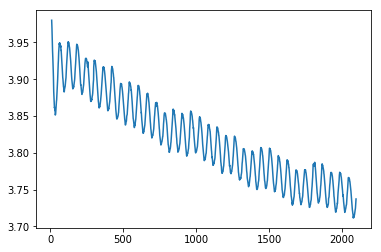

In [378]:
learner.sched.plot_loss()

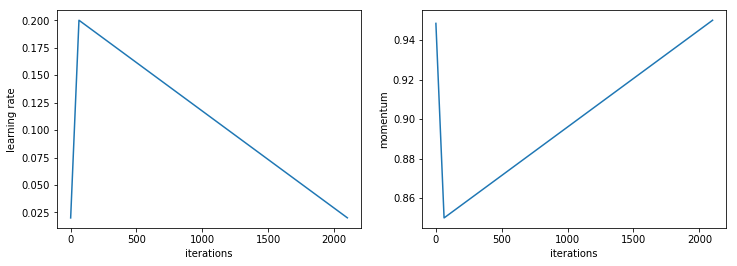

In [379]:
learner.sched.plot_lr()

#### Save weights

In [376]:
learner.save('lm_malay_class_final')

In [377]:
learner.save_encoder('lm_malay_class_enc_final')

**Train again**

In [364]:
learner.fit(lr, 1, wds=wd, cycle_len=50, use_clr=(10,33,0.95,0.85), best_save_name='best_lm_malay_class_1cycle')

epoch      trn_loss   val_loss   accuracy                 
    0      3.95441    4.069766   0.323256  
    1      3.961234   4.061223   0.324558                 
    2      3.932805   4.051805   0.32403                  
    3      3.924991   4.047925   0.325088                 
    4      3.915586   4.048385   0.325423                 
    5      3.916731   4.046061   0.324297                 
    6      3.900932   4.039335   0.325086                 
    7      3.8882     4.040588   0.32538                  
    8      3.886258   4.039876   0.325064                 
    9      3.876345   4.036779   0.325418                 
    10     3.864198   4.037971   0.32509                  
    11     3.862805   4.033976   0.32579                  
    12     3.859321   4.034552   0.325575                 
    13     3.851479   4.035933   0.325433                 
    14     3.837702   4.033878   0.325492                 
    15     3.839188   4.032169   0.325182                 
    16     3

[4.033368062973023, 0.3253615975379944]

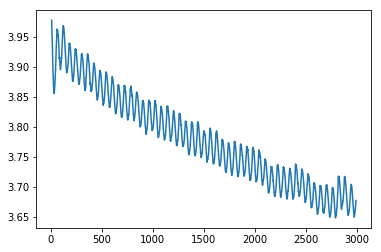

In [365]:
learner.sched.plot_loss()

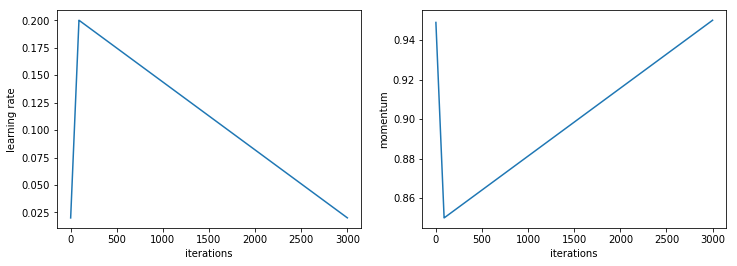

In [366]:
learner.sched.plot_lr()

In [367]:
# save weights
learner.save('lm_malay_class_1')

#### Results

The best model is `lm_malay_class_final`.

Let's see how our model did. Losses after 35 epochs:
- Training: 3.750099
- Validation: **4.027839**

Accuracy: 0.32585 (32.6%)

In [380]:
np.exp(4.027839)

56.13946269035133

**Analysis**:

The **perplexity** of this language model after 35 epochs is **56.13946** (accuracy of 32.6%).

On one Tesla K80 GPU, the full training took me ~20 minutes.

## Classifier tokens

Let's now create the classifier. We will go through this pretty quickly because it's the same.

In [381]:
chunksize = 10000
df_trn = pd.read_csv(DATASET_PATH / 'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(DATASET_PATH / 'test.csv', header=None, chunksize=chunksize)

In [382]:
# Tokenize text data
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0


In [383]:
# Create a tmp directory to store the upcoming numpy arrays
(TMP_PATH).mkdir(exist_ok=True)

# Save the train and validation tokens in the tmp directories
np.save(TMP_PATH / 'malaya_tok_trn.npy', tok_trn)
np.save(TMP_PATH / 'malaya_tok_val.npy', tok_val)

# Save the train and validation labels in the tmp directories
np.save(TMP_PATH / 'malaya_trn_labels.npy', trn_labels)
np.save(TMP_PATH / 'malaya_val_labels.npy', val_labels)

In [384]:
# Load Malaya tokens
tok_trn = np.load(TMP_PATH / 'malaya_tok_trn.npy')
tok_val = np.load(TMP_PATH / 'malaya_tok_val.npy')

We don't create a new `itos` vocabulary, we obviously want to use the same vocabulary we had in the language model because we are about to reload the same encoder.

In [385]:
itos = pickle.load(open(PKL_PATH / 'itos.pkl', 'rb'))

# Creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda: 0, {v:k for k, v in enumerate(itos)})
len(itos)

3826

In [386]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [387]:
np.save(TMP_PATH / 'malaya_trn_ids.npy', trn_clas)
np.save(TMP_PATH / 'malaya_val_ids.npy', val_clas)

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained 'Malaya' backbone. The steps to create the classifier model are similar to the ones for the LM.

_Note: the following codes originated from lesson 10 "transfer learning for NLP and NLP classification" notebooks._

In [388]:
trn_clas = np.load(TMP_PATH / 'malaya_trn_ids.npy')
val_clas = np.load(TMP_PATH / 'malaya_val_ids.npy')

In [389]:
trn_labels = np.squeeze(np.load(TMP_PATH / 'malaya_trn_labels.npy'))
val_labels = np.squeeze(np.load(TMP_PATH / 'malaya_val_labels.npy'))

The construction of the model hyper parameters are the same. We can change the dropout. Pick a batch size that is as big as you can that doesn't run out of memory.

In [436]:
bptt, em_sz, nh, nl = 70, 400, 1150, 3
vocab_size = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48
weight_factor = 0.9

In [393]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c = int(trn_labels.max()) + 1

**TextDataset**

The basic idea here is that for the classifier, we do really want to look at one document. Is this document positive or negative? So we do want to shuffle the documents. But those documents have different lengths and so if we stick them all into one batch (this is a handy thing that fastai does for you) — you can stick things of different lengths into a batch and it will automatically pad them, so you don't have to worry about that. But if they are wildly different lengths, then you're going to be wasting a lot of computation times.

In [394]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)

Turning it to a DataLoader:

In [395]:
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))

trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)

In [396]:
md = ModelData(DATASET_PATH, trn_dl, val_dl)

In [437]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.4]) * weight_factor # scale dropouts by weight factor

`get_rnn_classifer` going to create exactly the same encoder more or less, and we are going to pass in the same architectural details as before. But this time, with the head we add on, you have a few more things you can do. One is you can add more than one hidden layer.

In [438]:
m = get_rnn_classifer(bptt, 20 * 70, c, vocab_size, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
            layers=[em_sz * 3, 50, c], drops=[dps[4], 0.1],
            dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [439]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [440]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip = .25
learn.metrics = [accuracy]

We are going to use discriminative learning rates for different layers.

In [424]:
# lr = 3e-3
# lrm = 2.6
# lrs = np.array([lr / (lrm**4), lr / (lrm**3), lr / (lrm**2), lr / lrm, lr])

In [441]:
lrs = np.array([1e-4, 1e-4, 1e-4, 1e-3, 1e-2])

Weight decay

In [442]:
wd = 1e-7
wd = 0
learn.load_encoder('lm_malay_class_enc_final')

We start out just training the last layer.

In [443]:
learn.freeze_to(-1)

 83%|████████▎ | 443/536 [00:20<00:04, 19.50it/s, loss=2.96] 

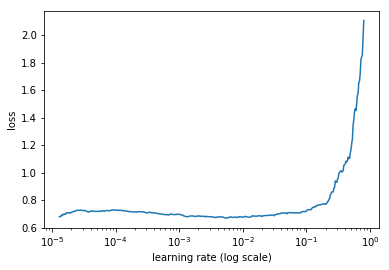

In [444]:
learn.lr_find(lrs / 1000)
learn.sched.plot()

In [445]:
learn.fit(lrs, 1, wds=wd, use_clr=(8, 3), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.651141   0.602677   0.678571  


[0.6026770397394645, 0.6785714531145176]

In [446]:
learn.save('clas_0')
learn.load('clas_0')

Then we unfreeze one more layer.

In [447]:
learn.freeze_to(-2)

In [448]:
learn.fit(lrs, 1, wds=wd, use_clr=(8, 3), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.649661   0.596921   0.680672  


[0.5969214133855676, 0.6806722909462553]

In [449]:
learn.save('clas_1')
learn.load('clas_1')

Then we fine-tune the whole thing.

In [450]:
learn.unfreeze()

In [451]:
%timeit
learn.fit(lrs, 1, wds=wd, use_clr=(32, 10), cycle_len=20)

epoch      trn_loss   val_loss   accuracy                    
    0      0.631502   0.592999   0.693277  
    1      0.617841   0.569909   0.696078                    
    2      0.614908   0.563406   0.704482                    
    3      0.612599   0.539441   0.722689                    
    4      0.585135   0.527522   0.723389                    
    5      0.57695    0.521039   0.72409                     
    6      0.565664   0.536092   0.733193                    
    7      0.545686   0.500306   0.7507                      
    8      0.553788   0.497672   0.740896                    
    9      0.510357   0.488029   0.752101                    
    10     0.549363   0.490817   0.763305                    
    11     0.530247   0.4814     0.766106                    
    12     0.515283   0.497648   0.767507                    
    13     0.516862   0.479391   0.771709                    
    14     0.496292   0.474485   0.772409                    
    15     0.489294   0.47

[0.47243087532139627, 0.7745098256263412]

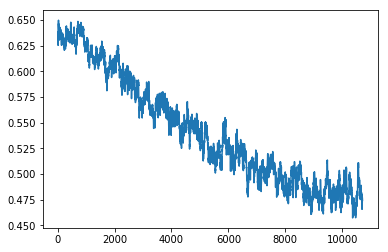

In [452]:
learn.sched.plot_loss()

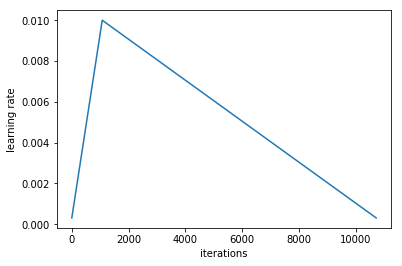

In [453]:
learn.sched.plot_lr()

In [454]:
learn.save('clas_2')

It took me ~1 minutes to train 1 epoch, roughly 8.00 iteration/s. The full training took me ~22 minutes.

## Validation Performance

Accuracy: **0.7745098256263412**

In [458]:
learn.load('clas_2')

# Get validation performance
probs, y = learner.predict_with_targs()
preds = np.argmax(np.exp(probs), 1)

In [ ]:
from sklearn.metrics import confusion_matrix

most_frequent = np.array([0] * len(preds))
print(f'Baseline Accuracy: {np.mean(y==most_frequent)}')
print(f'Micro Accuracy: {np.mean(y==preds)}')
cm = confusion_matrix(y,preds)
# plot_confusion_matrix(cm,classes=['neg','pos'])